In [1]:
import os ##冰激淋+擔擔麵+蜂蜜檸檬適用

os.environ["CUDA_VISIBLE_DEVICES"] = "1" #使用第0張顯卡 ##冰激淋+擔擔麵+蜂蜜檸檬適用 0or1

In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
import keras
from keras import regularizers
from keras import backend as K
from keras.layers import Input, LSTM, Dense, Dropout, Flatten, Convolution1D, MaxPooling1D, Activation, BatchNormalization,\
Lambda, Concatenate, Add, Conv2D, Conv1D,TimeDistributed
from keras.optimizers import Adam
from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import PReLU
from keras.models import Model
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from itertools import combinations
from itertools import permutations
from PIL import Image
import matplotlib.pyplot as plt
import psutil
import os
import numpy as np
import pandas as pd
import datetime
import warnings
import pickle
import csv
import random
from keras.models import Sequential
from keras import backend as K

In [4]:
"""
基本設定
"""
n=148335 #用2016 1~3月的資料 288x(31+29+31+30+31+30+...)=52416 210528-1(all) 差值在減一  
l=36 
currency = ["CHF","CAD","GBP","JPY","EUR","HKD"]
currencynum = len(currency)
month = [0,31,60,91,121,152,182,213,244,274,305,335,366,397,425,456,486,517,547,578,609,639,670,700,731] #2016是閏年 366天
daynum = [0,5803,11746,18352,24381,30580,36862,42796,49202,55343,61231,67401,73733,79985,85727,92344,98128,104693,111029,117077,123701,129808,136084,142402,148336]
#currency = ["BTC","DASH","ETH","LTC","JBY","GBP","EUR","AUD","US"]
question = ["trand","volatility"]
# 貨幣組合，1 : P, 0 : C
M=0

epochs = 30
batch_size = 4096

all_cur_pair = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
if(M==0):
    all_cur_pair_P = list(combinations(currency,2))# (Cn取2) 問題沒有先後順序時使用
elif(M==1):
    all_cur_pair_P = list(permutations(currency,2))# (Pn取2) 問題有先後順序時使用  
all_question= list(permutations(question,1))
np.set_printoptions(suppress=True)#不要用科學符號輸出

In [5]:
"""""""""
str, onehotcode, company code轉換
"""""""""
currencylist = {}
questionlist = {}
for i in range(len(currency)):
    currencylist[i] = currency[i]

for i in range(len(question)):
    questionlist[i] = question[i]

def str_to_currency(cur):
    return {v: k for k, v in currencylist.items()}[cur]

def str_to_question(q):
    return {v: k for k, v in questionlist.items()}[q]


def one_hot_currency(currencylist):
    d = {}
    temp = np.eye((len(currencylist)))
    for i in range(len(currencylist)):
        d[i] = temp[i]
    return d

def one_hot_question(questionlist):
    d = {}
    temp = np.eye((len(questionlist)))
    for i in range(len(questionlist)):
        d[i] = temp[i]
    return d

onehotcurrency = one_hot_currency(currencylist)
onehotquestion = one_hot_question(questionlist)

In [6]:
"""
Q&A
"""
vol='volatility'
def set_question(com1, com2, typeq):

    return np.concatenate((onehotquestion[str_to_question(typeq)],onehotcurrency[str_to_currency(com1)], onehotcurrency[str_to_currency(com2)]))

qtype = ['big']
HVqtype = ['big']

"""比漲幅程度類問題"""
def set_question_and_answer_pair(data, data2, n, all_cur_pair_P): #比較波動率大小的問題
    q_pair = {}
    a_pair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    #data_sum=np.sum(data,axis=1)
    data2_sum=np.sum(data2,axis=1)
    outcome[0]=(data2_sum[0])
    outcome[1]=(data2_sum[1])
    outcome[2]=(data2_sum[2])
    outcome[3]=(data2_sum[3])
    outcome[4]=(data2_sum[4])
    outcome[5]=(data2_sum[5])

    tmp_q = []
    tmp_a = []
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[0][0]))
    q_pair[i] = tmp_q        
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
    a_pair[i] = tmp_a
    return (data, q_pair, a_pair)


"""History Volatility類問題"""
def set_HVquestion_and_HVanswer_pair(data, data2,all_cur_pair_P): #比較波動率大小的問題
    q_HVpair = {}
    a_HVpair = {}
    outcome=np.zeros((currencynum,1))
    for c in range(currencynum):
        data2[c]=data2[c]-data2[c][0]
    data2_std=np.std(data2,axis=1) 
    outcome[0]=data2_std[0]
    outcome[1]=data2_std[1]
    outcome[2]=data2_std[2]
    outcome[3]=data2_std[3]
    outcome[4]=data2_std[4]
    outcome[5]=data2_std[5]     

    tmp_q = []
    tmp_a = []   
    for j in range(len(all_cur_pair_P)):
        tmp_q.append(set_question(all_cur_pair_P[j][0], all_cur_pair_P[j][1],all_question[1][0]))
    q_HVpair[i] = tmp_q
    for j in range(len(all_cur_pair_P)):
        if(outcome[str_to_currency(all_cur_pair_P[j][0])] >= outcome[str_to_currency(all_cur_pair_P[j][1])]):
            tmp_a.append(1)
        else:
            tmp_a.append(0)
                
    a_HVpair[i] = tmp_a    
    return (data, q_HVpair, a_HVpair)

In [7]:
"""
網路函數
"""
def ConvolutionNetworks(filter_num,kernel_size):
    def conv(model):
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = Conv1D(filter_num, kernel_size, activation='relu')(model)
        model = (MaxPooling1D(pool_size=5))(model)
        model = BatchNormalization()(model)
        return model
    return conv

def get_dense(n, MLP_unit):
    r = []
    for k in range(n):
        r.append(Dense(MLP_unit, activation='relu'))
    return r

def get_MLP(n, denses):
    def g(x):
        d = x
        for k in range(n):
            d = denses[k](d)
        return d
    return g

def dropout_dense(x,MLP_unit):
    y = Dense(MLP_unit)(x)
    y = Dropout(0.5)(y)
    y = Activation('relu')(y)
    return y

def build_tag(conv):
    d = K.int_shape(conv)[1]
    tag = np.zeros((d,1))
    for i in range(d):
        tag[i] = float(int(i%d))/(d-1)*2-1
    tag = K.variable(tag)
    tag = K.expand_dims(tag,axis=0)
    batch_size = K.shape(conv)[0]
    tag = K.tile(tag,[batch_size,1,1])
    print(K.int_shape(tag))
    return Input(tensor=tag)

In [10]:

"""
rolling
"""

def fit_show(traindata,m1,m2,m3):
    
    vqa_pair = []
    for i in range(0,m3-m1-l-l,1):
        vqa_pair.append(set_question_and_answer_pair(Train_data[i],Train_data[i+l],i+l-1,all_cur_pair_P))  
        vqa_pair.append(set_HVquestion_and_HVanswer_pair(Train_data[i],Train_data[i+l],all_cur_pair_P))
        #這裡交叉塞資料才不會不小心預測未來
            
    # 處理訓練資料
    v_tmp, q_tmp, a_tmp = [],[],[]
    for i in range(len(vqa_pair)):
        v_tmp.append(vqa_pair[i][0])
        q_tmp.append(vqa_pair[i][1])
        a_tmp.append(vqa_pair[i][2])
    v = np.array(v_tmp)
    
    # 下面這行會導致memory error
    import tracemalloc
    # Start tracing
    tracemalloc.start()
    v = np.repeat(v, len(all_cur_pair_P)*len(qtype), axis = 0)
    #這裡要注意問題的分類數量(2種:波動和漲跌)已經在前面vqa_pair變成兩倍過了
    #這裡只要考慮貨幣組合數量(P的N取2)和問的問題數量(高低同)
    snap = tracemalloc.take_snapshot()
    # Evaluate result
    stats = snap.statistics('lineno')
    for stat in stats[:1]:
        print(stat)
    
    q, a = [],[]
    for i in range(len(q_tmp)):
        for value in q_tmp[i].values():
            q.append(value)
    q = np.vstack(q)
    q = np.vstack(q)
    
    for i in range(len(a_tmp)):
        for value in a_tmp[i].values():
            a.append(value)
    a = np.vstack(a)
    a = a.reshape(a.shape[0]*a.shape[1])
    v=np.swapaxes(v,1,2)
    print("[Training model......]")

    Train_v=v[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]# -1-72+1=-72
    Train_q=q[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Train_a=a[:((m2-m1)-l*2)*len(all_cur_pair_P)*len(qtype)*2]
    Test_v=v[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_q=q[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    Test_a=a[((m2-m1))*len(all_cur_pair_P)*len(qtype)*2:]
    
    history = model.fit([Train_v, Train_q], Train_a, validation_data=([Test_v,Test_q],Test_a),batch_size=batch_size ,epochs = epochs,shuffle=False)
    pred = model.predict([Test_v, Test_q])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    cycle = ((currencynum*(currencynum-1))/2)*len(question)*len(qtype)
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q[ii])
            a_trend.append(Test_a[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q[ii])
            a_vol.append(Test_a[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])

    print("reverse section--------------------------------------------------------------------------")
    Test_q_reverse=Test_q
    temp=Test_q_reverse[:,2:8]
    Test_q_reverse[:,2:8]=Test_q_reverse[:,8:14]
    Test_q_reverse[:,8:14]=temp
    Test_a_reverse=-1*Test_a+1
    pred = model.predict([Test_v, Test_q_reverse])
    count = 0
    print(pred)
    for i in range(pred.shape[0]):
        if pred[i] <= 0.5:
            pred[i] = 0
        else:
            pred[i] = 1
            
        if pred[i] == Test_a_reverse[i]:
            count+=1
    print(count,count/pred.shape[0])
    """
    分開兩種問題的test集
    """
    flag=0
    v_trend=[]
    q_trend=[]
    a_trend=[]
    v_vol=[]
    q_vol=[]
    a_vol=[]
    trend_count=0
    vol_count=0
    for ii in range(0,len(Test_q)):
        if(flag==0):
            #print(0)
            v_trend.append(Test_v[ii])
            q_trend.append(Test_q_reverse[ii])
            a_trend.append(Test_a_reverse[ii])
            trend_count=trend_count+1
            if(trend_count==cycle):
                trend_count=0
                flag=1
        elif(flag==1):
            #print(1)
            v_vol.append(Test_v[ii])
            q_vol.append(Test_q_reverse[ii])
            a_vol.append(Test_a_reverse[ii])
            vol_count=vol_count+1
            if(vol_count==cycle):
                vol_count=0
                flag=0
    
    """
    分開兩種問題的predict正確率
    """
    pred_trend = model.predict([v_trend, q_trend])
    count = 0
    for i in range(pred_trend.shape[0]):
        if pred_trend[i] <= 0.5:
            pred_trend[i] = 0
        else:
            pred_trend[i] = 1
            
        if pred_trend[i] == a_trend[i]:
            count+=1
    print("trend_test_acc:")
    print(count,count/pred_trend.shape[0])    
    total_test_trend.append(count/pred_trend.shape[0])

    pred_vol = model.predict([v_vol, q_vol])
    count = 0
    for i in range(pred_vol.shape[0]):
        if pred_vol[i] <= 0.5:
            pred_vol[i] = 0
        else:
            pred_vol[i] = 1
            
        if pred_vol[i] == a_vol[i]:
            count+=1
    print("vol_test_acc:")
    print(count,count/pred_vol.shape[0]) 
    total_test_vol.append(count/pred_vol.shape[0])
    
    """
    benchmark1
    """
    benchacc=0
    for i in range(Test_a.shape[0]):
        benchacc=benchacc+Test_a[i]
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("猜答案多的那邊 benchacc1:")
    print(benchacc)

    """
    benchmark2
    """
    #第一個直接猜1
    benchacc=0
    for i in range(Test_a.shape[0]-1):
        if(Test_a[i]!=Test_a[i+1]):
            benchacc=benchacc+1
    benchacc=benchacc/Test_a.shape[0]    
    if(benchacc<0.5):
        benchacc=1-benchacc
    print("參考前一個答案 benchacc2:")
    print(benchacc)    
    
    """
    畫圖
    """
    benchfunction=np.ones(a.shape[0])
    benchfunction=benchfunction*benchacc
    plt.plot(history.history['loss'], label='train')
    lastepoch_train_loss.append(history.history['loss'][-1])
    plt.plot(history.history['val_loss'], label='test')
    lastepoch_test_loss.append(history.history['val_loss'][-1])
    print("loss:")
    print(history.history['loss'][-1])
    print("val_loss:")
    print(history.history['val_loss'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("loss") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()
    
    
    plt.plot(history.history['acc'], label='train')
    lastepoch_train_acc.append(history.history['acc'][-1])
    plt.plot(history.history['val_acc'], label='test')
    lastepoch_test_acc.append(history.history['val_acc'][-1])  
    plt.plot(np.arange(epochs),np.repeat(benchacc,epochs), label='benchmark')
    print("acc:")
    print(history.history['acc'][-1])
    print("val_acc:")
    print(history.history['val_acc'][-1])
    plt.xlabel("epoch") 
    plt.ylabel("acc") 
    #plt.title("The Title") 
    plt.legend()
    plt.show()

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1202 MiB, count=2, average=601 MiB
[Training model......]
Train on 556170 samples, validate on 171360 samples
Epoch 1/30
556170/556170 [==============================] - 8s 13us/step - loss: 0.7280 - acc: 0.4876 - val_loss: 0.6867 - val_acc: 0.5360
Epoch 2/30
556170/556170 [==============================] - 4s 6us/step - loss: 0.6903 - acc: 0.5228 - val_loss: 0.6789 - val_acc: 0.5654
Epoch 3/30
556170/556170 [==============================] - 4s 7us/step - loss: 0.6801 - acc: 0.5473 - val_loss: 0.6703 - val_acc: 0.5796
Epoch 4/30
556170/556170 [==============================] - 4s 6us/step - loss: 0.6725 - acc: 0.5628 - val_loss: 0.6629 - val_acc: 0.5893
Epoch 5/30
556170/556170 [==============================] - 3s 6us/step - loss: 0.6658 - acc: 0.5761 - val_loss: 0.6565 - val_acc: 0.5992
Epoch 6/30
556170/556170 [==============

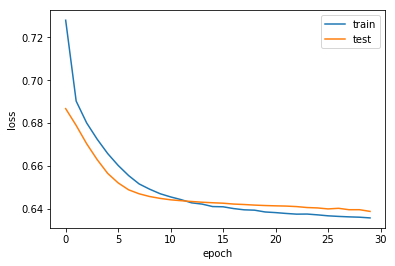

acc:
0.6138195157496913
val_acc:
0.6047677398952338


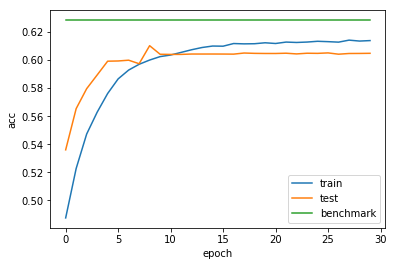

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1218 MiB, count=88, average=13.8 MiB
[Training model......]
Train on 542130 samples, validate on 194790 samples
Epoch 1/30
542130/542130 [==============================] - 7s 12us/step - loss: 0.6972 - acc: 0.5217 - val_loss: 0.6772 - val_acc: 0.5677
Epoch 2/30
542130/542130 [==============================] - 3s 6us/step - loss: 0.6792 - acc: 0.5550 - val_loss: 0.6678 - val_acc: 0.5816
Epoch 3/30
542130/542130 [==============================] - 4s 7us/step - loss: 0.6697 - acc: 0.5737 - val_loss: 0.6597 - val_acc: 0.5828
Epoch 4/30
542130/542130 [==============================] - 3s 6us/step - loss: 0.6621 - acc: 0.5866 - val_loss: 0.6532 - val_acc: 0.6020
Epoch 5/30
542130/542130 [==============================] - 3s 6us/step - loss: 0.6565 - acc: 0.5950 - val_loss: 0.6489 - val_acc: 0.6052
Epoch 6/30
542130/542130 [============

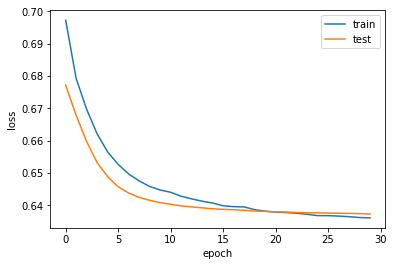

acc:
0.6132090088804966
val_acc:
0.6082601772801907


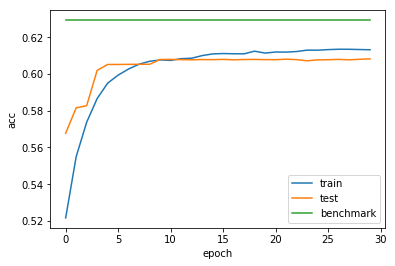

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1247 MiB, count=89, average=14.0 MiB
[Training model......]
Train on 566820 samples, validate on 187920 samples
Epoch 1/30
566820/566820 [==============================] - 7s 13us/step - loss: 0.7674 - acc: 0.4940 - val_loss: 0.6809 - val_acc: 0.5617
Epoch 2/30
566820/566820 [==============================] - 4s 6us/step - loss: 0.6960 - acc: 0.5301 - val_loss: 0.6755 - val_acc: 0.5848
Epoch 3/30
566820/566820 [==============================] - 4s 7us/step - loss: 0.6813 - acc: 0.5534 - val_loss: 0.6682 - val_acc: 0.5912
Epoch 4/30
566820/566820 [==============================] - 4s 7us/step - loss: 0.6714 - acc: 0.5726 - val_loss: 0.6611 - val_acc: 0.5946
Epoch 5/30
566820/566820 [==============================] - 4s 7us/step - loss: 0.6632 - acc: 0.5850 - val_loss: 0.6554 - val_acc: 0.5965
Epoch 6/30
566820/566820 [============

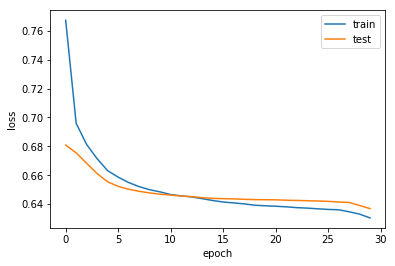

acc:
0.6132811122419957
val_acc:
0.6042039167175601


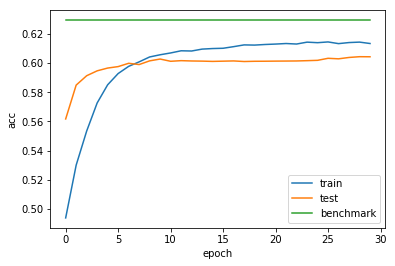

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1219 MiB, count=90, average=13.5 MiB
[Training model......]
Train on 558390 samples, validate on 179280 samples
Epoch 1/30
558390/558390 [==============================] - 7s 13us/step - loss: 0.7195 - acc: 0.5214 - val_loss: 0.6813 - val_acc: 0.5853
Epoch 2/30
558390/558390 [==============================] - 4s 6us/step - loss: 0.6856 - acc: 0.5518 - val_loss: 0.6714 - val_acc: 0.5947
Epoch 3/30
558390/558390 [==============================] - 4s 7us/step - loss: 0.6725 - acc: 0.5746 - val_loss: 0.6619 - val_acc: 0.5946
Epoch 4/30
558390/558390 [==============================] - 4s 7us/step - loss: 0.6638 - acc: 0.5862 - val_loss: 0.6560 - val_acc: 0.5950
Epoch 5/30
558390/558390 [==============================] - 3s 6us/step - loss: 0.6569 - acc: 0.5950 - val_loss: 0.6523 - val_acc: 0.6018
Epoch 6/30
558390/558390 [============

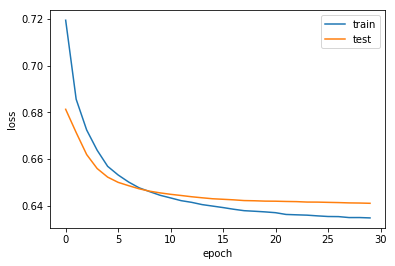

acc:
0.6152062179003053
val_acc:
0.6041778224060335


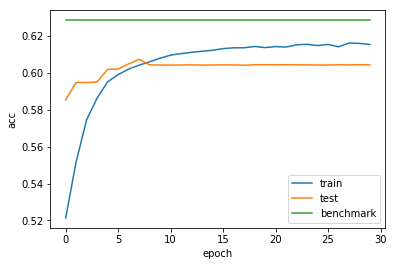

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1261 MiB, count=91, average=13.9 MiB
[Training model......]
Train on 566310 samples, validate on 196560 samples
Epoch 1/30
566310/566310 [==============================] - 8s 13us/step - loss: 0.7466 - acc: 0.5232 - val_loss: 0.6884 - val_acc: 0.5425
Epoch 2/30
566310/566310 [==============================] - 4s 6us/step - loss: 0.6961 - acc: 0.5344 - val_loss: 0.6784 - val_acc: 0.5425
Epoch 3/30
566310/566310 [==============================] - 4s 7us/step - loss: 0.6809 - acc: 0.5526 - val_loss: 0.6694 - val_acc: 0.5754
Epoch 4/30
566310/566310 [==============================] - 4s 6us/step - loss: 0.6691 - acc: 0.5730 - val_loss: 0.6619 - val_acc: 0.5930
Epoch 5/30
566310/566310 [==============================] - 4s 7us/step - loss: 0.6609 - acc: 0.5881 - val_loss: 0.6577 - val_acc: 0.5981
Epoch 6/30
566310/566310 [============

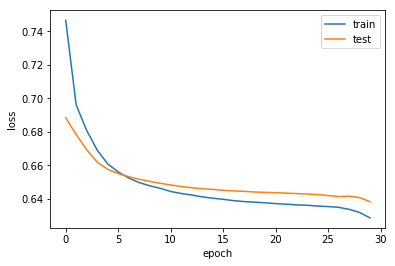

acc:
0.6147233847131439
val_acc:
0.5997150997199515


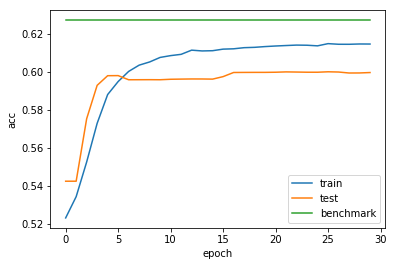

In [12]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])
    

In [13]:
batch_size = 1024

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
12
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1202 MiB, count=92, average=13.1 MiB
[Training model......]
Train on 556170 samples, validate on 171360 samples
Epoch 1/30
556170/556170 [==============================] - 15s 27us/step - loss: 0.6912 - acc: 0.5444 - val_loss: 0.6636 - val_acc: 0.6018
Epoch 2/30
556170/556170 [==============================] - 13s 24us/step - loss: 0.6613 - acc: 0.5917 - val_loss: 0.6509 - val_acc: 0.5998
Epoch 3/30
556170/556170 [==============================] - 13s 24us/step - loss: 0.6514 - acc: 0.6047 - val_loss: 0.6476 - val_acc: 0.6036
Epoch 4/30
556170/556170 [==============================] - 13s 23us/step - loss: 0.6470 - acc: 0.6100 - val_loss: 0.6456 - val_acc: 0.6040
Epoch 5/30
556170/556170 [==============================] - 14s 25us/step - loss: 0.6441 - acc: 0.6112 - val_loss: 0.6447 - val_acc: 0.6039
Epoch 6/30
556170/556170 [===

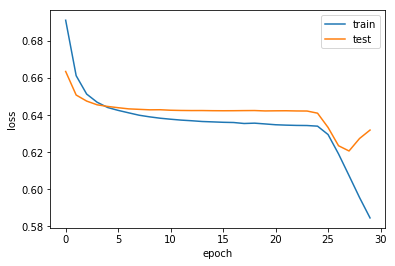

acc:
0.6522789794456217
val_acc:
0.6093429038727206


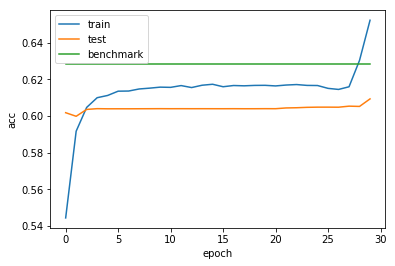

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
13
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1218 MiB, count=92, average=13.2 MiB
[Training model......]
Train on 542130 samples, validate on 194790 samples
Epoch 1/30
542130/542130 [==============================] - 17s 32us/step - loss: 0.6891 - acc: 0.5459 - val_loss: 0.6597 - val_acc: 0.5851
Epoch 2/30
542130/542130 [==============================] - 13s 24us/step - loss: 0.6587 - acc: 0.5908 - val_loss: 0.6477 - val_acc: 0.6025
Epoch 3/30
542130/542130 [==============================] - 13s 25us/step - loss: 0.6496 - acc: 0.6047 - val_loss: 0.6424 - val_acc: 0.6078
Epoch 4/30
542130/542130 [==============================] - 13s 23us/step - loss: 0.6451 - acc: 0.6090 - val_loss: 0.6400 - val_acc: 0.6078
Epoch 5/30
542130/542130 [==============================] - 13s 24us/step - loss: 0.6423 - acc: 0.6110 - val_loss: 0.6389 - val_acc: 0.6078
Epoch 6/30
542130/542130 [===

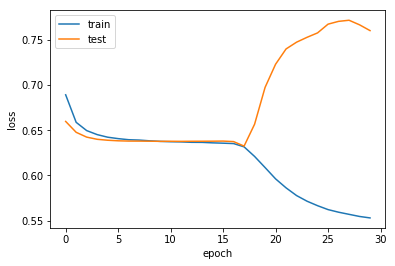

acc:
0.6673307140226253
val_acc:
0.602197238033487


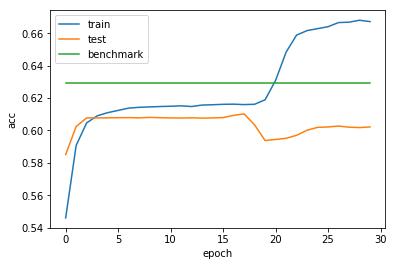

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
14
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1247 MiB, count=92, average=13.6 MiB
[Training model......]
Train on 566820 samples, validate on 187920 samples
Epoch 1/30
566820/566820 [==============================] - 17s 30us/step - loss: 0.6845 - acc: 0.5563 - val_loss: 0.6561 - val_acc: 0.5915
Epoch 2/30
566820/566820 [==============================] - 14s 24us/step - loss: 0.6555 - acc: 0.5996 - val_loss: 0.6479 - val_acc: 0.6014
Epoch 3/30
566820/566820 [==============================] - 13s 23us/step - loss: 0.6479 - acc: 0.6080 - val_loss: 0.6449 - val_acc: 0.6019
Epoch 4/30
566820/566820 [==============================] - 14s 25us/step - loss: 0.6440 - acc: 0.6110 - val_loss: 0.6440 - val_acc: 0.6024
Epoch 5/30
566820/566820 [==============================] - 14s 24us/step - loss: 0.6415 - acc: 0.6127 - val_loss: 0.6432 - val_acc: 0.6030
Epoch 6/30
566820/566820 [===

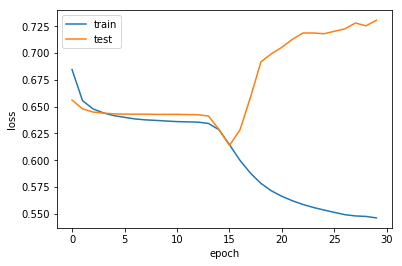

acc:
0.6676511061565494
val_acc:
0.5937792677278466


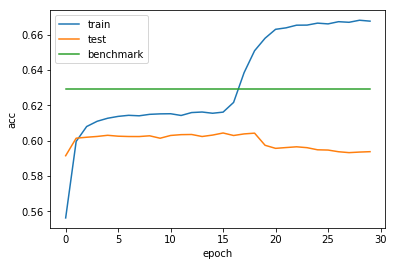

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
15
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1219 MiB, count=92, average=13.3 MiB
[Training model......]
Train on 558390 samples, validate on 179280 samples
Epoch 1/30
558390/558390 [==============================] - 17s 31us/step - loss: 0.6986 - acc: 0.5328 - val_loss: 0.6702 - val_acc: 0.5756
Epoch 2/30
558390/558390 [==============================] - 12s 22us/step - loss: 0.6640 - acc: 0.5817 - val_loss: 0.6520 - val_acc: 0.6004
Epoch 3/30
558390/558390 [==============================] - 13s 23us/step - loss: 0.6523 - acc: 0.5994 - val_loss: 0.6464 - val_acc: 0.6018
Epoch 4/30
558390/558390 [==============================] - 12s 21us/step - loss: 0.6467 - acc: 0.6068 - val_loss: 0.6439 - val_acc: 0.6018
Epoch 5/30
558390/558390 [==============================] - 13s 24us/step - loss: 0.6431 - acc: 0.6110 - val_loss: 0.6431 - val_acc: 0.6019
Epoch 6/30
558390/558390 [===

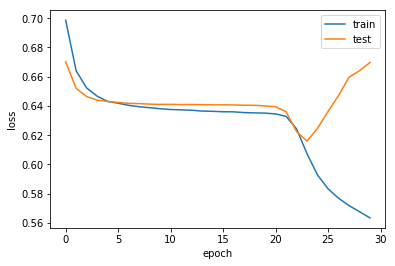

acc:
0.6623077060876179
val_acc:
0.6152164212458371


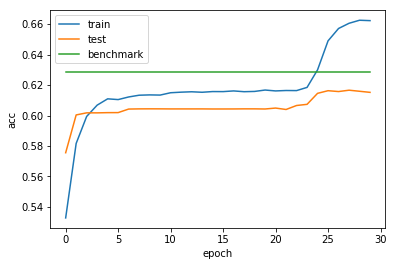

(148335, 1)
finish dataread
(None, 4, 1)
g_MLP
drop_out
compile model success
16
/opt/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: size=1261 MiB, count=92, average=13.7 MiB
[Training model......]
Train on 566310 samples, validate on 196560 samples
Epoch 1/30
566310/566310 [==============================] - 19s 34us/step - loss: 0.7008 - acc: 0.5447 - val_loss: 0.6605 - val_acc: 0.5857
Epoch 2/30
566310/566310 [==============================] - 14s 25us/step - loss: 0.6584 - acc: 0.5915 - val_loss: 0.6484 - val_acc: 0.5946
Epoch 3/30
566310/566310 [==============================] - 14s 25us/step - loss: 0.6484 - acc: 0.6030 - val_loss: 0.6463 - val_acc: 0.5979
Epoch 4/30
566310/566310 [==============================] - 13s 23us/step - loss: 0.6444 - acc: 0.6076 - val_loss: 0.6451 - val_acc: 0.6002
Epoch 5/30
566310/566310 [==============================] - 13s 24us/step - loss: 0.6421 - acc: 0.6097 - val_loss: 0.6445 - val_acc: 0.6001
Epoch 6/30
566310/566310 [===

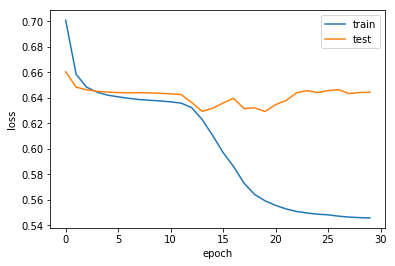

acc:
0.66753368296495
val_acc:
0.5941086691814464


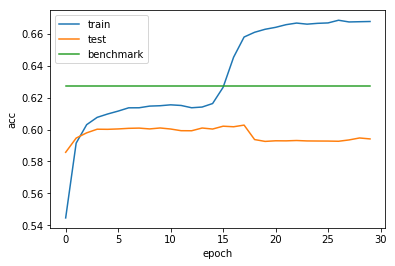

In [14]:
lastepoch_train_acc = []
lastepoch_test_acc = []
lastepoch_train_loss = []
lastepoch_test_loss = []
total_test_vol = []
total_test_trend = []
head = 12
tail = 17
for z in range(head,tail,1):
    n=daynum[tail]-daynum[head]
    df = pd.read_csv('data/JPY_data_ver2.0.csv',header=None)  # 讀取訓練數據
    print(df.shape)  
    jpy5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        jpy5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/EUR_data_ver2.0.csv',header=None)  # 讀取訓練數據
    eur5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        eur5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CHF_data_ver2.0.csv',header=None)  # 讀取訓練數據
    chf5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        chf5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/CAD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    cad5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        cad5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/GBP_data_ver2.0.csv',header=None)  # 讀取訓練數據
    gbp5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        gbp5months[dt] = df[0][i]  
        dt=dt+1
    df = pd.read_csv('data/HKD_data_ver2.0.csv',header=None)  # 讀取訓練數據
    hkd5months = np.zeros(n)
    dt=0
    for i in range(daynum[head],daynum[tail],1):
        hkd5months[dt] = df[0][i]  
        dt=dt+1
    print('finish dataread')
    Train_data=np.zeros(((n-l+1,len(currency),l)))
    for p in range(n-l+1):
        Train_data[p,0,:]=chf5months[p:p+l]
        Train_data[p,1,:]=cad5months[p:p+l]
        Train_data[p,2,:]=gbp5months[p:p+l]
        Train_data[p,3,:]=jpy5months[p:p+l]
        Train_data[p,4,:]=eur5months[p:p+l]
        Train_data[p,5,:]=hkd5months[p:p+l]
    
    MLP_unit=64
    visual_scene = Input((l,currencynum))
    visual_conv = ConvolutionNetworks(20,5)(visual_scene)
    tag = build_tag(visual_conv)
    visual_conv = Concatenate()([visual_conv, tag])
    shapes = visual_conv.shape
    w = shapes[1]
    features= []
    for k1 in range(w):
        def get_feature(t):
            return t[:, k1, :]
        get_feature_layer = Lambda(get_feature)
        features.append(get_feature_layer(visual_conv))

    input2 = Input((14,))
    onehot_encode = input2   

    relations = []
    concat = Concatenate()
    for feature1 in features:
        for feature2 in features:
            relations.append(concat([feature1, feature2, onehot_encode]))    


    g_MLP = get_MLP(5, get_dense(5,MLP_unit))
    f_MLP = get_MLP(5, get_dense(5,MLP_unit))
    print("g_MLP")
    mid_relations = []
    for r in relations:
        mid_relations.append(g_MLP(r))

    combined_relation = Add()(mid_relations)

    #f_MLP
    rn = dropout_dense(combined_relation,MLP_unit)
    rn = dropout_dense(rn,MLP_unit)
    print('drop_out')

    pred = Dense(1, activation = 'sigmoid')(rn)

    model = Model(inputs=[visual_scene, input2, tag], outputs = pred)
    optimizer = Adam(lr = 3e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    print('compile model success')    

    #model.summary()
    print(z)
    fit_show(Train_data,daynum[z],daynum[z+3],daynum[z+4])